In [1]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def run(
	grid_n_vals: list[int] = [2,3,4,5,6,7] + np.logspace(3, 6, 7, base=2, dtype=int).tolist(),
	n_mazes_vals: list[int] = np.logspace(0, 3, 4, base=2, dtype=int)
):
	print(f"{grid_n_vals=}\n{n_mazes_vals=}")

	# run the benchmark
	from benchmark_generation import run_benchmark

	df: pd.DataFrame = run_benchmark(
		save_path = "benchmark_temp.jsonl",
		base_configs = None, # this defaults to DEFAULT_GENERATORS
		grid_n_vals = grid_n_vals,
		n_mazes_vals = n_mazes_vals,
		trials = 10,
		verbose = False,
	)

# run()

In [3]:
# or just load the results
df: pd.DataFrame = pd.read_json("benchmark_large.jsonl", orient="records", lines=True)

In [4]:
# Convert the `maze_ctor_kwargs` column to string type for easier grouping
df['maze_ctor_kwargs_json'] = df['maze_ctor_kwargs'].apply(lambda x: json.dumps(x, sort_keys=True))

# Group the data by the maze generation method (`maze_ctor`) and `maze_ctor_kwargs`, and calculate the average time to generate a *single* maze in milliseconds (ms)
grouped_df = df.groupby(['maze_ctor', 'maze_ctor_kwargs_json']).apply(lambda x: (x['time'].sum() / x['n_mazes'].sum()) * 1000).reset_index()
grouped_df.columns = ['Maze Generation Method', 'Maze Constructor Arguments', 'Average Time (ms)']

# Apply the formatting function to the 'maze_ctor_kwargs' column
grouped_df['Maze Constructor Arguments'] = grouped_df['Maze Constructor Arguments'].apply(lambda x: ','.join(f"{k}={v}" for k,v in json.loads(x).items()))

# Generate the LaTeX table
print(grouped_df)
latex_table = grouped_df.to_latex(index=False, float_format="%.3f")

print(latex_table)

   Maze Generation Method               Maze Constructor Arguments  \
0                 gen_dfs                      accessible_cells=20   
1                 gen_dfs                           do_forks=False   
2                 gen_dfs                       max_tree_depth=0.5   
3                 gen_dfs                                            
4     gen_dfs_percolation                                    p=0.1   
5     gen_dfs_percolation                                    p=0.4   
6         gen_percolation                                    p=1.0   
7                gen_prim  accessible_cells=0.5,max_tree_depth=0.5   
8                gen_prim                     accessible_cells=0.5   
9                gen_prim                           do_forks=False   
10               gen_prim                       max_tree_depth=0.5   
11               gen_prim                                            
12             gen_wilson                                            

    Average Time (m

C:\Users\mivan\AppData\Local\Temp\ipykernel_11892\831155250.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = grouped_df.to_latex(index=False, float_format="%.3f")


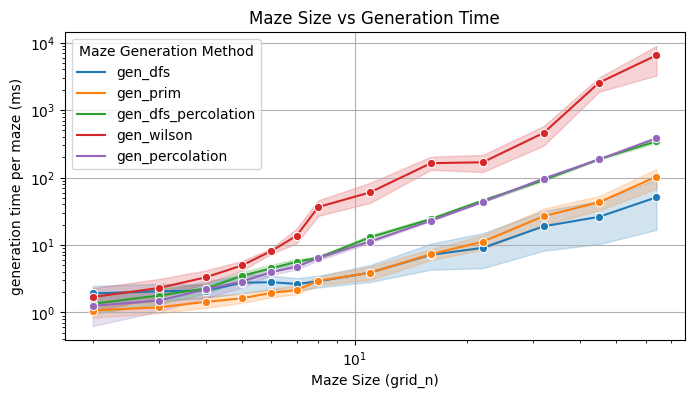

In [5]:
# Convert the 'time' to milliseconds for easier interpretation in the plot
df['time_ms'] = df['time'] * 1000
df['time_normalized'] = df['time_ms'] / df['n_mazes']
# select only rows where n_mazes == 32
# df_selected = df[df['n_mazes'] == 32]
# Plot maze size vs generation time for each method
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='grid_n', y='time_normalized', hue='maze_ctor', marker='o')
plt.title('Maze Size vs Generation Time')
plt.xlabel('Maze Size (grid_n)')
plt.ylabel('generation time per maze (ms)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Maze Generation Method')
plt.grid(True)
plt.savefig('gridsize-vs-gentime.pdf')
plt.show()

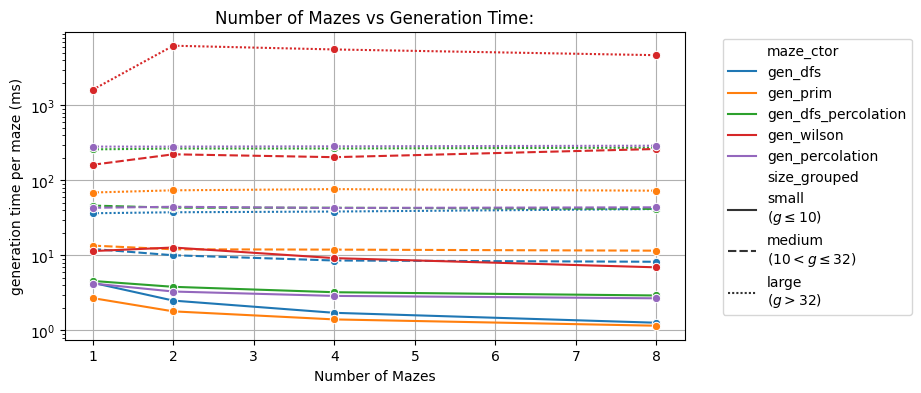

In [6]:
# Plot number of mazes vs generation time for each method and maze size
# for each of the unique maze_ctor

_size_map = lambda x: (
	"small\n($g \\leq 10)$" if x <= 10 else
	"medium\n($10 < g \\leq 32$)" if x <= 32 else
	"large\n($g > 32$)"
)

df["size_grouped"] = df["grid_n"].apply(_size_map)

plt.figure(figsize=(8, 4))
sns.lineplot(
	data=df,
	x='n_mazes', 
	y='time_normalized', 
	hue='maze_ctor',
	style='size_grouped',
	marker='o', 
	errorbar=None,
	# logarithmic colormap
	# palette=sns.color_palette("flare", as_cmap=True),
	# make legend contain all labels
	legend='full',
)
plt.title(f'Number of Mazes vs Generation Time:')
plt.xlabel('Number of Mazes')
plt.ylabel('generation time per maze (ms)')
# plt.xscale('log')
plt.yscale('log')
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.savefig('n_mazes-vs-gentime.pdf')
plt.show()

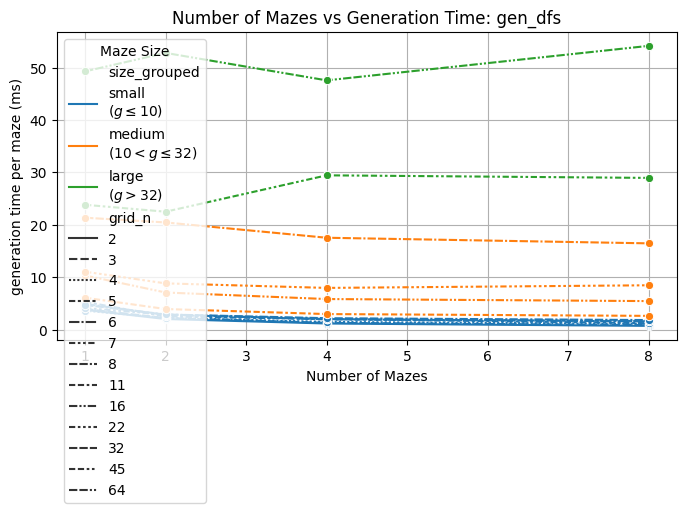

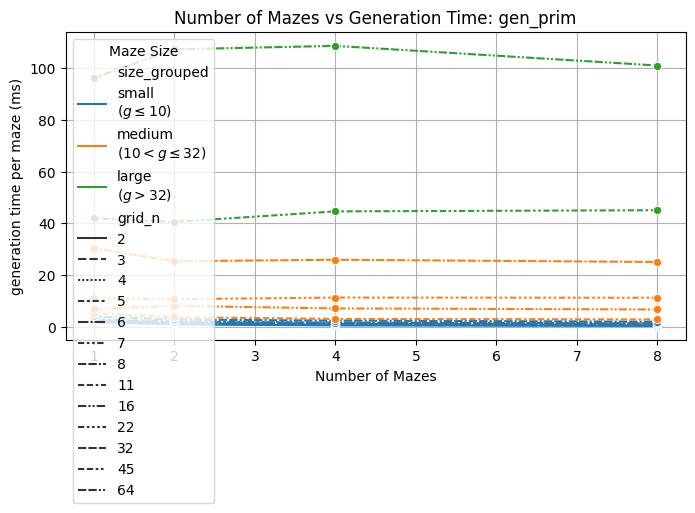

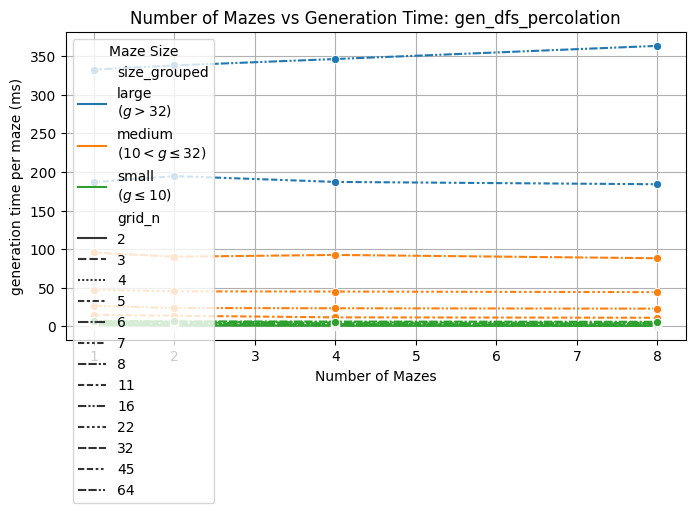

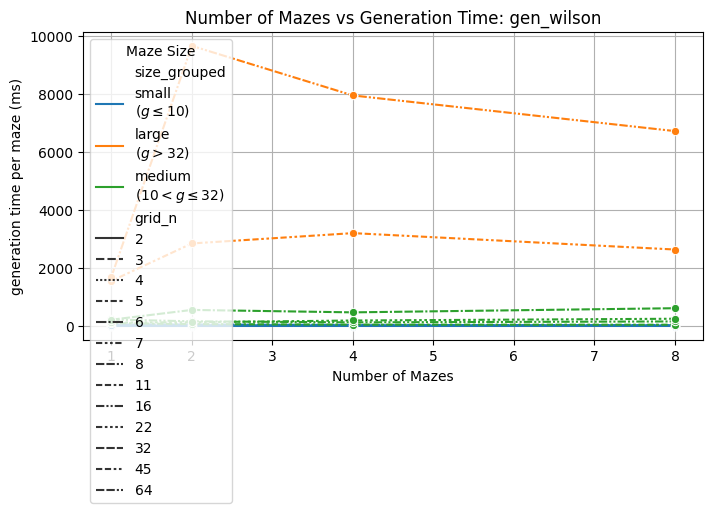

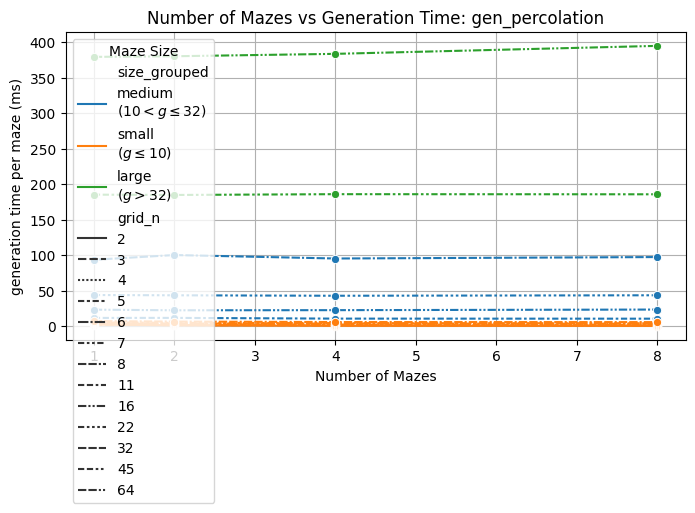

In [7]:

for maze_ctor in df['maze_ctor'].unique():
	plt.figure(figsize=(8, 4))
	sns.lineplot(
		data=df[df['maze_ctor'] == maze_ctor],
		x='n_mazes', 
		y='time_normalized', 
		hue='size_grouped', 
		style='grid_n',
		marker='o', 
		errorbar=None,
		# logarithmic colormap
		# palette=sns.color_palette("flare", as_cmap=True),
		# make legend contain all labels
		legend='full',
	)
	plt.title(f'Number of Mazes vs Generation Time: {maze_ctor}')
	plt.xlabel('Number of Mazes')
	plt.ylabel('generation time per maze (ms)')
	# plt.xscale('log')
	# plt.yscale('log')
	plt.legend(title='Maze Size', loc='upper left')
	plt.grid(True)
	plt.show()

<Axes: title={'center': 'Benchmark'}, xlabel='Number of mazes', ylabel='Time (s)'>

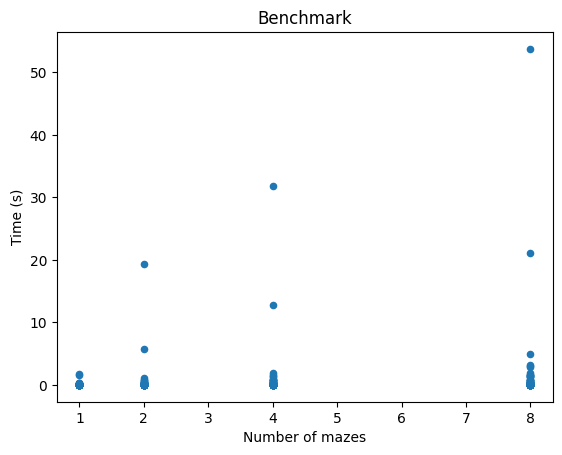

In [8]:
# plot the results
df.plot(
	x = "n_mazes",
	y = "time",
	kind = "scatter",
	# logx = True,
	# logy = True,
	title = "Benchmark",
	xlabel = "Number of mazes",
	ylabel = "Time (s)",
)